Import Libraries

In [1]:
import csv
import os
import shutil
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
from collections import defaultdict
import tensorflow as tf
import matplotlib.pyplot as plt

Nessecary File

In [2]:
DATA_FIX_PATH = '../dataset/UNTR.csv'

with open(DATA_FIX_PATH, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

timestamp,close

First data point looks like this:

2001-04-16,312

Second data point looks like this:

2001-04-17,312



Visualize the Stock Price

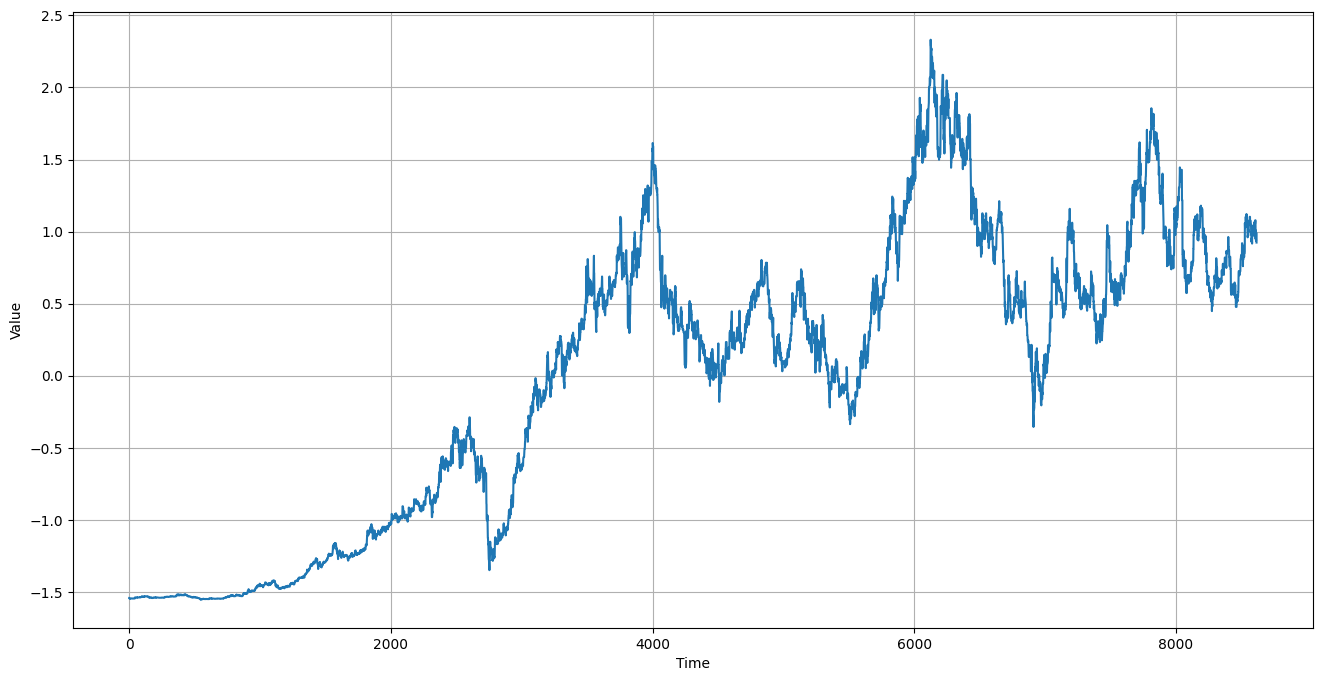

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    """Plot the series"""
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def parse_data_from_file(filename):
    data = np.loadtxt(filename, delimiter=',', skiprows=1, usecols=1)
    closedStockPrice = data.astype(float)
    
    # Normalisasi yang lebih robust
    mean = np.mean(closedStockPrice)
    std = np.std(closedStockPrice)
    closedStockPrice = (closedStockPrice - mean) / std
    
    times = np.arange(len(data))
    
    return times, closedStockPrice, mean, std

TIME, SERIES, mean, std = parse_data_from_file(DATA_FIX_PATH)

plt.figure(figsize=(16, 8))
plot_series(TIME, SERIES)

Defining Global Variables

In [4]:
SPLIT_TIME = 7000
WINDOW_SIZE = 224
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000

Processing the Data

In [5]:
def train_val_split(time, series):
    """ Splits time series into train and validations sets"""
    time_train = time[:SPLIT_TIME]
    series_train = series[:SPLIT_TIME]
    time_valid = time[SPLIT_TIME:]
    series_valid = series[SPLIT_TIME:]

    return time_train, series_train, time_valid, series_valid

In [6]:
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(TIME, SERIES)

In [7]:
def windowed_dataset(series, window_size):
    """Creates windowed dataset"""
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

In [8]:
# Apply the transformation to the training set
train_dataset = windowed_dataset(series_train, window_size=WINDOW_SIZE)

Defining the Model Architecture

In [9]:
def create_model():
    model = tf.keras.models.Sequential([ 
        tf.keras.Input(shape=(WINDOW_SIZE, 1)),
        
        # First Conv1D layer dengan lebih banyak filter
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, 
                               strides=1, padding="causal", 
                               activation="relu"),
        tf.keras.layers.BatchNormalization(),  # Menambah stabilitas
        
        # LSTM layers dengan ukuran yang lebih besar
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),  
        
        tf.keras.layers.LSTM(32),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Dense(16, activation="relu", 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # L2 regularization
        tf.keras.layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    model.compile(
        loss=tf.keras.losses.Huber(delta=1.0),  # Huber loss untuk stabilitas
        optimizer=optimizer,
        metrics=["mae"]
    )
    
    return model

In [10]:
model = create_model()

In [11]:
example_batch = train_dataset.take(1)

try:
	predictions = model.predict(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	print("Your current architecture is compatible with the windowed dataset! :)")
	print(f"predictions have shape: {predictions.shape}")

Your current architecture is compatible with the windowed dataset! :)
predictions have shape: (64, 1)


d:\Download\Miniconda\envs\capstone\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [12]:
print(f'Model input shape: {model.input_shape}')
print(f'Model output shape: {model.output_shape}')

Model input shape: (None, 224, 1)
Model output shape: (None, 1)


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 224, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 224, 64)        │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 224, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,433 (150.13 KB)

 Trainable params: 38,177 (149.13 KB)

 Non-trainable params: 256 (1.00 KB)

In [14]:
# Callbacks untuk training yang lebih baik
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

In [15]:
# Create dataset and train
train_dataset = windowed_dataset(series_train, WINDOW_SIZE)
validation_dataset = windowed_dataset(series_valid, WINDOW_SIZE)

In [16]:
# Train model
history = model.fit(
    train_dataset,
    epochs=50,  # Lebih banyak epochs dengan early stopping
    validation_data=validation_dataset,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - loss: 0.3686 - mae: 0.4501 - val_loss: 0.2750 - val_mae: 0.4116 - learning_rate: 0.0010
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - loss: 0.5032 - mae: 0.6707 - val_loss: 0.1665 - val_mae: 0.2111 - learning_rate: 0.0010
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - loss: 0.3591 - mae: 0.5300 - val_loss: 0.1475 - val_mae: 0.2440 - learning_rate: 0.0010
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - loss: 0.2711 - mae: 0.4424 - val_loss: 0.1504 - val_mae: 0.2977 - learning_rate: 0.0010
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step - loss: 0.2295 - mae: 0.4217 - val_loss: 0.1445 - val_mae: 0.3214 - learning_rate: 0.0010
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - loss: 0.1914 - mae: 0.3849 - val_loss: 0.1081 - val_mae: 0.2593 - learning_rate: 0.0010
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - loss: 0.1423 - mae: 0.3125 - val_loss: 0.1565 - val_mae: 0.4218 - learnin

Visualize the training loss

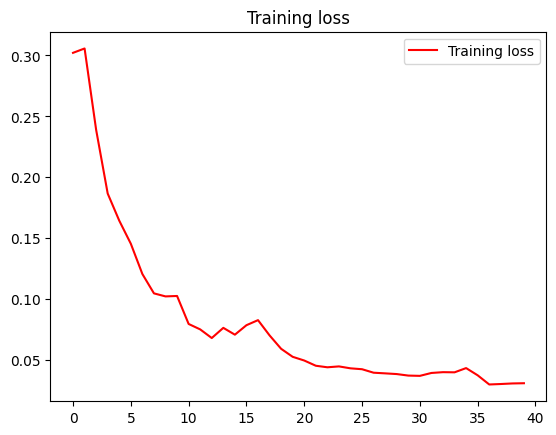

In [17]:
# Plot the training loss for each epoch

loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.show()

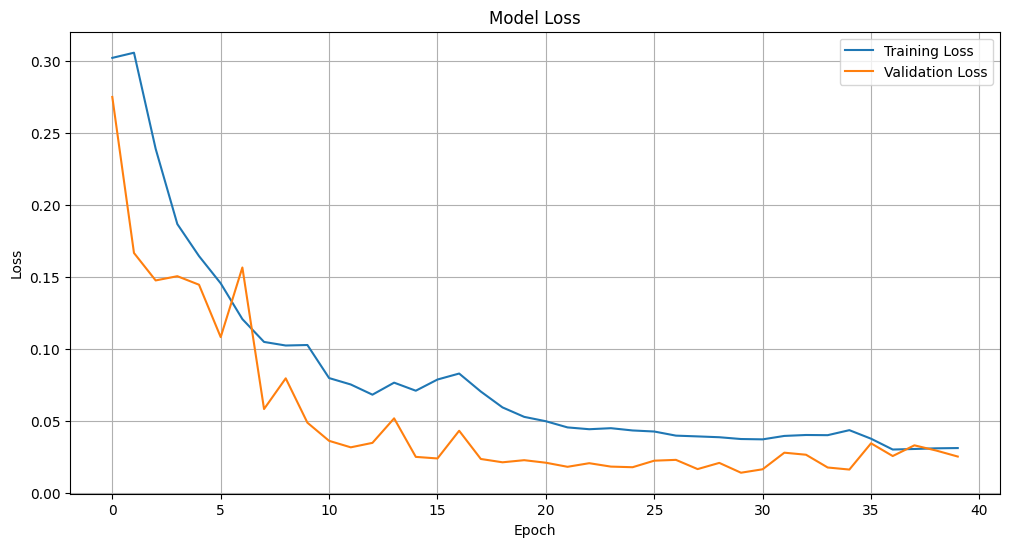

In [18]:
# Plot training metrics
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Evaluating the forecast

In [19]:
def compute_metrics(true_series, forecast):
    """Computes MSE and MAE metrics for the forecast"""
    mse = tf.keras.losses.MSE(true_series, forecast)
    mae = tf.keras.losses.MAE(true_series, forecast)
    return mse, mae

Model forecast

In [20]:
def model_forecast(model, series, window_size):
    """Generates a forecast using your trained model"""
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(tf.data.AUTOTUNE)
    forecast = model.predict(ds, verbose=0)
    return forecast

In [21]:
# Compute the forecast for the validation dataset. Remember you need the last WINDOW SIZE values to make the first prediction
rnn_forecast = model_forecast(model, SERIES[SPLIT_TIME-WINDOW_SIZE:-1], WINDOW_SIZE).squeeze()

# Denormalisasi prediksi dan data validasi
rnn_forecast = rnn_forecast * std + mean
series_valid_denorm = series_valid * std + mean

Visualize the forecast

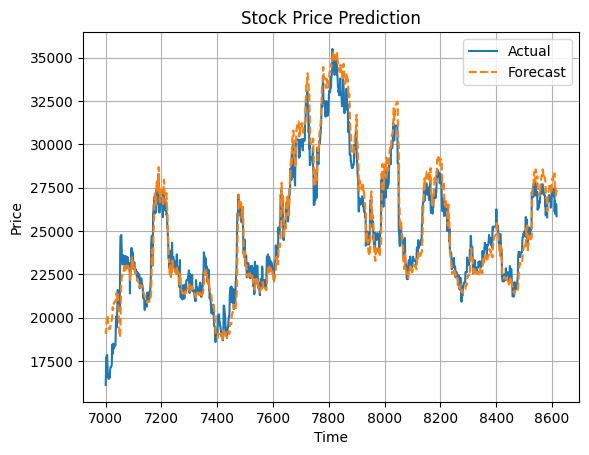

In [22]:
# Plot the forecast
plt.plot(time_valid, series_valid_denorm, label='Actual')
plt.plot(time_valid, rnn_forecast, label='Forecast', linestyle='--')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
mse, mae = compute_metrics(series_valid_denorm, rnn_forecast)
print(f"mse: {mse.numpy():.2f}, mae: {mae.numpy():.2f} for forecast")

mse: 925556.76, mae: 733.40 for forecast


Pada konteks model regresi, "accuracy" biasanya tidak dihitung karena itu adalah metrik yang lebih umum digunakan untuk klasifikasi. Sebagai gantinya, metrik seperti Mean Squared Error (MSE) atau Mean Absolute Error (MAE) digunakan untuk mengevaluasi kinerja model regresi.

Namun, jika tetap ingin mencetak akurasi berdasarkan toleransi tertentu (misalnya, prediksi dianggap benar jika perbedaannya dengan nilai aktual berada dalam rentang tertentu), 

In [24]:
def calculate_accuracy(true_values, predicted_values, tolerance=0.05):
    """
    Menghitung akurasi berdasarkan toleransi tertentu.
    Akurasi dihitung sebagai persentase prediksi yang berada dalam batas toleransi.

    Parameters:
    - true_values: Array nilai sebenarnya.
    - predicted_values: Array nilai prediksi.
    - tolerance: Toleransi absolut atau persentase untuk menentukan apakah prediksi benar.

    Returns:
    - Akurasi dalam persen.
    """
    differences = np.abs(true_values - predicted_values)
    within_tolerance = differences <= (tolerance * true_values)
    accuracy = np.mean(within_tolerance) * 100  # Menghitung persentase
    return accuracy

In [25]:
# Hitung akurasi
tolerance = 0.05  # Toleransi 5%
accuracy = calculate_accuracy(series_valid_denorm, rnn_forecast, tolerance=tolerance)

print(f"Akurasi model (dengan toleransi {tolerance*100:.1f}%): {accuracy:.2f}%")

Akurasi model (dengan toleransi 5.0%): 87.58%


In [ ]:
# Menyimpan model ke direktori SavedModel
model.save('./saveModel')

In [26]:
# Menyimpan model dalam format HDF5
model.save('model.h5')